In [1]:
from umap.umap_ import UMAP
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import wandb
import json
import os
import glob
from topk_sae import FastAutoencoder, loss_fn, unit_norm_decoder_grad_adjustment_, unit_norm_decoder_, init_from_data_
import autointerp
import numpy as np
import umap
import matrix
import pandas as pd

torch.set_grad_enabled(False)

d_model = 1536
n_dirs = d_model * 6
k = 64
auxk = 128
multik = 256
batch_size = 1024

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

ae = FastAutoencoder(n_dirs, d_model, k, auxk, multik = multik).to(device)
model_path = 'checkpoints/64_9216_128_auxk_epoch_50.pth'
ae.load_state_dict(torch.load(model_path))
ae.eval()

abstract_embeddings = np.load("../data/vector_store/abstract_embeddings.npy")
abstract_embeddings = abstract_embeddings.astype(np.float32)

dataset = TensorDataset(torch.from_numpy(abstract_embeddings))
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

%load_ext autoreload
%autoreload 2

auto_results = json.load(open('sae_data/feature_analysis_results.json'))
auto_embeds = np.load('sae_data/feature_embeddings.npy')
auto_labels = open('sae_data/feature_labels.txt').read().splitlines()
abstract_texts = json.load(open('../data/vector_store/abstract_texts.json'))['abstracts']
num_abstracts = len(abstract_embeddings)
topk_indices = np.load("sae_data/topk_indices.npy")
topk_values = np.load("sae_data/topk_values.npy")

/Users/christineye/anaconda3/envs/jsalt-retrieval/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Exploring Firings

Text(0.5, 0, 'firing ratio')

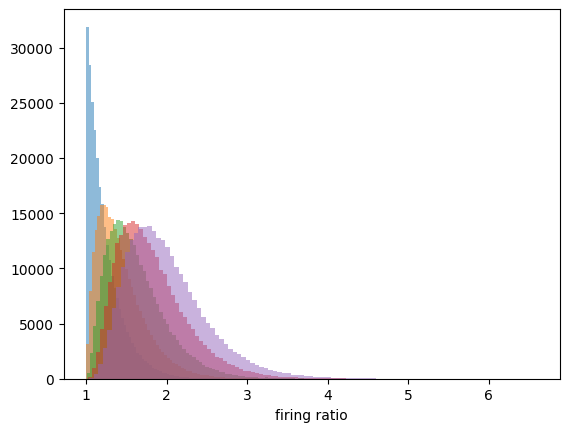

In [9]:
hist = plt.hist(topk_values[:, 0]/topk_values[:, 1], bins=100, alpha = 0.5)
hist = plt.hist(topk_values[:, 0]/topk_values[:, 2], bins=100, alpha = 0.5)
hist = plt.hist(topk_values[:, 0]/topk_values[:, 3], bins=100, alpha = 0.5)
hist = plt.hist(topk_values[:, 0]/topk_values[:, 4], bins=100, alpha = 0.5)
hist = plt.hist(topk_values[:, 0]/topk_values[:, 5], bins=100, alpha = 0.5)
plt.xlabel('firing ratio')

In [9]:
def get_feature_list(indices, auto_results):
    k = len(indices)
    feature_list = [""] * k
    for result in auto_results:
        if result['index'] in indices:
            feature_list[list(indices).index(result['index'])] = result['label']
    
    return feature_list

In [59]:
def filt_indices():
    good_indices = []
    for result in auto_results:
        if result['f1'] > 0.6 and result['pearson_correlation'] > 0.6:
            if result['label'] in auto_labels:
                good_indices.append(result['index'])
    return good_indices

In [54]:
# looking at examples that fire multiple neurons equally strongly
id = np.argsort(topk_values[:, 0]/topk_values[:, 1])[3]
print(get_feature_list(topk_indices[id][:5]))
print(abstract_texts[id])

['Polarimetry in space missions', 'Blazars and associated phenomena', 'BL Lac object S5 0716+714', 'Variability in astronomical phenomena', 'S stars and s-process elements']
['The intraday variations of the polarization vector direction in radio source S5 0716+714']

The bright radio source S5 0716+714, which is usually classified as a BL Lac object, is one of the most intensively studied blazar. S5 0716+714 demonstrates extremely peculiar properties, such as the shortest time-scale of optical and polarimetric variations observed in blazars. In this paper, we present the results of a 9-h polarimetric monitoring of S5 0716+714 with a ∼70-s resolution carried out using the 6-m telescope BTA of the Special Astrophysical Observatory of the Russian Academy of Sciences (SAO RAS). An anaysis of the observations reveals variability in both the total and the polarized light on a time-scale of 1-1.5 hr. Because polarization is generated by plasma motion in the magnetic field, the variations of t

In [60]:
kept_ids = filt_indices()
kept_n = np.zeros(len(topk_indices))
for i, paper in enumerate(topk_indices):
    kept_n[i] = len(set(paper).intersection(kept_ids))

Text(0.5, 0, '# kept features')

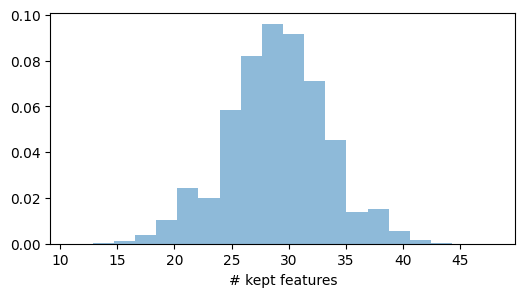

In [69]:
fig = plt.subplots(1, figsize=(6, 3))
plt.hist(kept_n, bins = 20, density = True, alpha = 0.5)
plt.xlabel('# kept features')

# Feature Clamping

In [ ]:
import clamp

In [200]:
clean_labels = clamp.get_clean_labels(auto_results)
all_scores = clamp.get_all_scores(list(clean_labels.keys())[:150])

Processing 2 batches
scores 50 50
scores 100 100


In [252]:
len(all_scores) # wow multi-threading!

3305

In [381]:
from autointerp import NeuronAnalyzer
analyzer = NeuronAnalyzer('../config.yaml', 691, 5)

In [831]:
top_abstracts, zero_abstracts = analyzer.get_feature_activations(15, feature_index = clean_labels['Phosphorus'])

In [125]:
filt_to_all_map = {}
for result in auto_results:
    if result['f1'] >= 0.6 and result['pearson_correlation'] >= 0.6:
        auto_i = auto_labels.index(result['label'])
        if auto_i in filt_to_all_map.keys():
            # print('repeat', auto_i, result['index'], auto_labels[auto_i], result['label'])
            filt_to_all_map[auto_i].append(result['index'])
        else:
            filt_to_all_map[auto_i] = [result['index']]

In [8]:
abstract_ids = json.load(open('../data/vector_store/abstract_texts.json'))['doc_ids']
metadata = json.load(open('../data/vector_store/metadata.json'))
metadata_by_id = {metadata[item]['id']: metadata[item] for item in metadata}
titles = [metadata_by_id[i]['title'] for i in abstract_ids[:50000]]

In [ ]:
new_embs = np.loadtxt('sae_data/abstract_embeddings_methodology.npy')

In [262]:
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine')
umap_embeddings = umap_model.fit_transform(new_embs)
umap_df = pd.DataFrame(umap_embeddings, columns=['UMAP1', 'UMAP2'])

In [766]:
#umap_df.to_csv('sae_data/umap_embeddings_clamped.csv', index=False)
umap_df = pd.read_csv('sae_data/umap_embeddings_clamped.csv')
umap_df_2 = umap_df[5000:15000]
umap_df_2['title'] = titles[5000:15000]

/var/folders/kg/0g3xrys53nd6r_vs_7tph9y00000gn/T/ipykernel_36915/479638409.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [767]:
import pandas as pd
import plotly.express as px
import numpy as np

# Create the scatter plot
fig = px.scatter(
    umap_df_2,
    x='UMAP1',
    y='UMAP2',
    hover_data=['title'],
    title='UMAP Scatter Plot (prior)',
    color_continuous_scale='Inferno',
)

# Customize the hover template
fig.update_traces(
    hovertemplate='<b>%{customdata[0]}</b>'
)
fig.update_traces(marker={'size': 2})

# Adjust layout
fig.update_layout(
    width=800, 
    height=600,
)

# Save figure as PDF
# fig.write_image('../results/umap_scatter_plot.pdf')

# Show the plot
fig.show()

In [202]:
all_scores = json.load(open('sae_data/claude_scores_methodology.json'))

In [ ]:
multiplier = clamp.get_multiplier(ae.n_dirs, all_scores, clean_labels) 
new_embs = clamp.recompute_embeddings(ae, dataloader, multiplier, device)

In [171]:
diffs = np.sum((new_embs - abstract_embeddings) ** 2, axis = 1)
order = np.argsort(diffs)
n = -130
print(abstract_texts[order[n]])
print(order[n])

['HOLISMOKES. IX. Neural network inference of strong-lens parameters and uncertainties from ground-based images']

Modeling of strong gravitational lenses is a necessity for further applications in astrophysics and cosmology. With the large number of detections in current and upcoming surveys, such as the Rubin Legacy Survey of Space and Time (LSST), it is pertinent to investigate automated and fast analysis techniques beyond the traditional and time-consuming Markov chain Monte Carlo sampling methods. Building upon our (simple) convolutional neural network (CNN), we present here another CNN, specifically a residual neural network (ResNet), that predicts the five mass parameters of a singular isothermal ellipsoid (SIE) profile (lens center x and y, ellipticity e<SUB>x</SUB> and e<SUB>y</SUB>, Einstein radius θ<SUB>E</SUB>) and the external shear (γ<SUB>ext, 1</SUB>, γ<SUB>ext, 2</SUB>) from ground-based imaging data. In contrast to our previous CNN, this ResNet further predicts the 1σ 

In [ ]:
# good examples: 7, 47514, 243836

In [179]:
clamp.nn_search(243836, new_embs, 5)

[('[\'HOLISMOKES. IX. Neural network inference of strong-lens parameters and uncertainties from ground-based images\']\n\nModeling of strong gravitational lenses is a necessity for further applications in astrophysics and cosmology. With the large number of detections in current and upcoming surveys, such as the Rubin Legacy Survey of Space and Time (LSST), it is pertinent to investigate automated and fast analysis techniques beyond the traditional and time-consuming Markov chain Monte Carlo sampling methods. Building upon our (simple) convolutional neural network (CNN), we present here another CNN, specifically a residual neural network (ResNet), that predicts the five mass parameters of a singular isothermal ellipsoid (SIE) profile (lens center x and y, ellipticity e<SUB>x</SUB> and e<SUB>y</SUB>, Einstein radius θ<SUB>E</SUB>) and the external shear (γ<SUB>ext, 1</SUB>, γ<SUB>ext, 2</SUB>) from ground-based imaging data. In contrast to our previous CNN, this ResNet further predicts 

In [210]:
clamp.nn_search(243836, abstract_embeddings, 5)

[('[\'HOLISMOKES. IX. Neural network inference of strong-lens parameters and uncertainties from ground-based images\']\n\nModeling of strong gravitational lenses is a necessity for further applications in astrophysics and cosmology. With the large number of detections in current and upcoming surveys, such as the Rubin Legacy Survey of Space and Time (LSST), it is pertinent to investigate automated and fast analysis techniques beyond the traditional and time-consuming Markov chain Monte Carlo sampling methods. Building upon our (simple) convolutional neural network (CNN), we present here another CNN, specifically a residual neural network (ResNet), that predicts the five mass parameters of a singular isothermal ellipsoid (SIE) profile (lens center x and y, ellipticity e<SUB>x</SUB> and e<SUB>y</SUB>, Einstein radius θ<SUB>E</SUB>) and the external shear (γ<SUB>ext, 1</SUB>, γ<SUB>ext, 2</SUB>) from ground-based imaging data. In contrast to our previous CNN, this ResNet further predicts 

#  Feature Splitting

In [6]:
import networkx as nx
import clamp

In [324]:
clean_labels = clamp.get_clean_labels(auto_results)
clean_labels_by_id = {clean_labels[label]['index']: label for label in clean_labels.keys()}

In [12]:
sorted(clean_labels.values(), key = lambda x: x['density'], reverse=True)

[{'index': 7320,
  'density': 0.30406196822029213,
  'f1': 1.0,
  'pearson_correlation': 0.9897433186107872},
 {'index': 1879,
  'density': 0.2573905869006313,
  'f1': 0.8571428571428571,
  'pearson_correlation': 0.7342881617441562},
 {'index': 4834,
  'density': 0.2533941818235394,
  'f1': 0.8571428571428571,
  'pearson_correlation': 0.7645458696117137},
 {'index': 3295,
  'density': 0.23920233964654836,
  'f1': 1.0,
  'pearson_correlation': 0.9965881852095091},
 {'index': 310,
  'density': 0.23762219422897007,
  'f1': 1.0,
  'pearson_correlation': 0.979044296534892},
 {'index': 1943,
  'density': 0.19267460791030372,
  'f1': 0.6666666666666666,
  'pearson_correlation': 0.662266178532522},
 {'index': 4875,
  'density': 0.18588256094057326,
  'f1': 0.8571428571428571,
  'pearson_correlation': 0.6343870088614951},
 {'index': 4689,
  'density': 0.1836394174456894,
  'f1': 0.8571428571428571,
  'pearson_correlation': 0.7871630679206372},
 {'index': 4275,
  'density': 0.17344029702313862,


In [328]:
mat = np.load('unnorm_cooccurrence.npy')
norms = np.load('occurrence_norms.npy')
clean_cooc = matrix.get_norm_cooc(mat, norms, clean_labels, threshold = 0.07, poisson = True)

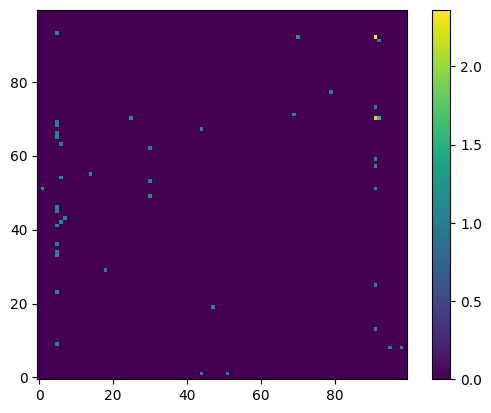

In [329]:
plt.imshow(clean_cooc[:100, :100], origin = 'lower')
plt.colorbar()

In [611]:
G_sort = nx.topological_sort(G)
topological_order = list(G_sort)

In [705]:
i = 573
print(node_names[i])
#print(np.array(node_names)[node_neighbors(G, i, "up")])

# Sort node_neighbors by density
neighbors = matrix.node_neighbors(G, i, "up")
sorted_neighbors = sorted(neighbors, key=lambda x: node_density[x], reverse=True)

print(np.array(node_names)[sorted_neighbors])

Metallicity
['Galactic halo properties and dynamics' 'Extreme astronomical phenomena'
 'Stellar clusters' 'Dust properties and evolution'
 'Detailed properties of galaxies' 'Dwarf galaxies and their properties'
 'Detailed studies of individual galaxies'
 '[C II] 158 μm emission and SFR' 'Early Universe and Early-Type Galaxies'
 'Radial velocity measurements'
 'Cosmological parameters and modified gravity theories'
 'Astrophysical relations (luminosity, mass, velocity)'
 'Iron (Fe) emission lines' 'Hubble Space Telescope observations'
 'Astronomical distance measurement techniques' 'Ionization'
 'Lyman-alpha and Lyman-beta emissions' 'Fine-Structure Constant (α)'
 'Interstellar Medium Properties and Processes'
 'Ratios in Astrophysical Measurements' 'Galaxy groups'
 'Ultraviolet (UV) emission' 'Blue astronomical phenomena' 'Host galaxies'
 'High redshift massive galaxy evolution'
 'High accretion rate AGNs and Quasars' 'Gaia mission and related aspects'
 'Feedback mechanisms in galaxy f

In [357]:
G_tree_directed = matrix.make_MST(clean_cooc, clean_labels)

In [140]:
matrix.node_neighbors(G_tree_directed, 'Upper limits and constraints', "down")

['Thresholds in Astrophysical Processes',
 'Haumea and its properties',
 'Saturation mechanisms',
 'Fundamental constants and cosmological models',
 'Hysteresis',
 'Nuclear pasta in dense astrophysical environments',
 'Reverse shocks in GRBs',
 'Pebble accretion in planet formation',
 'Collisions and Interaction Dynamics',
 'Decoherence in quantum cosmology',
 'Directional WIMP detection and statistics',
 'Needlets in CMB data analysis',
 'Habitability of exomoons',
 'Lyman-Werner radiation and black hole formation',
 'Radiation and magnetic field interactions with matter',
 'Positivity bounds in EFTs',
 'Tidal interactions in planetary systems',
 'Energy conditions in cosmology',
 'Superconducting devices, polarization, numerical methods',
 'Sedna and inner Oort Cloud',
 'Cherenkov Radiation and Techniques',
 'Lorentz Invariance Violation (LIV)',
 'Mutual Information in Astronomy',
 'Dyson spheres and related technosignatures']

In [253]:
clean_labels = clamp.get_clean_labels(auto_results)

In [354]:
all_subtrees = matrix.subtree_iterate(mat, norms, G_tree_directed, clean_labels, n = 3)

Text(0, 0.5, 'n subtrees')

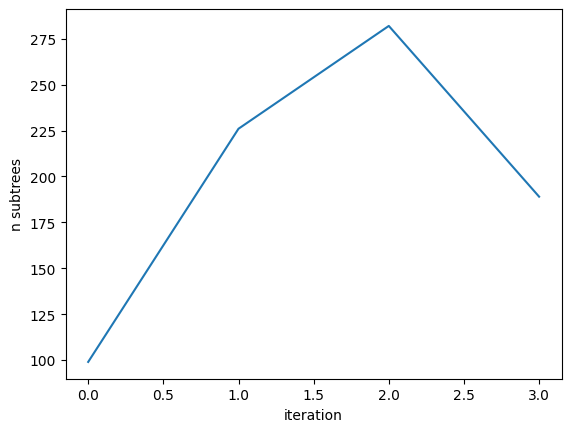

In [355]:
plt.plot([len(subtree) for subtree in all_subtrees])
plt.xlabel('iteration')
plt.ylabel('n subtrees')

In [51]:
nx.write_graphml(G_tree_directed, 'mst.graphml')

In [363]:
families = {}
for iteration in all_subtrees:
    for subtree in iteration:
        superfeature, children = matrix.print_subtree(subtree, clean_labels, all_children = [], verbose = False)
        if len(children) > 3:
            families[superfeature] = children

In [364]:
tally = 0
clean_families = {}
for family in families:
    for family2 in families:
        if family != family2:
            intersection = set(families[family]).intersection(families[family2])
            scale = min(len(families[family]), len(families[family2]))
            ratio = max(len(families[family]) / len(families[family2]), len(families[family2]) / len(families[family]))
            if len(intersection) / scale > 0.7 and ratio < 1.5:
                # print(family, family2, intersection, scale, ratio)
                tally += 1
            else:
                if len(families[family]) > len(families[family2]): clean_families[family] = families[family]
                else: clean_families[family2] = families[family2]

In [365]:
clean_families

{'Machine learning': [('Convolutional Neural Networks', 180),
  ('Deep learning', 725),
  ('Neural networks', 6279),
  ('Regression analysis', 7802),
  ('Generative Adversarial Networks (GANs)', 5270),
  ('Artificial Neural Networks', 1446),
  ('Automation and Machine Learning', 610),
  ('Use of autoencoders', 4538),
  ('Denoising techniques', 1824),
  ('Histograms in Data Analysis', 3495),
  ('Artificial Intelligence', 5709),
  ('Gaussian Processes', 1019),
  ('Prediction/Forecasting', 6046)],
 'Exotic and non-standard stellar objects': [('Magellanic Stream', 28),
  ('Open cluster M67 studies', 30),
  ('Astrophysical winds and driving mechanisms', 51),
  ('Solar wind properties and models', 7922),
  ('Point-Spread Function and Coaddition Techniques', 67),
  ('Stellar flares and high-cadence photometry', 138),
  ('HK Survey and Ca II H & K lines', 149),
  ('ISO-SWS Calibration and Modelling', 175),
  ('Runaway stars', 245),
  ('Entrainment', 258),
  ('Stellar Evolutionary Tracks and Is

In [366]:
json.dump(clean_families, open('clean_families.json', 'w'))

In [367]:
full_graph = matrix.make_graph(clean_cooc, clean_labels, directed = True)

# Searching for highly abstract features

In [ ]:
text = """"""

In [816]:
import sys
import yaml
from openai import OpenAI
sys.path.append('../evaluation')
from vector_store import EmbeddingClient
config = yaml.safe_load(open('../config.yaml'))
embedding_client = EmbeddingClient(OpenAI(api_key=config['openai_api_key']))

In [395]:
abstract_candidates = []
for result in auto_results:
    if result['f1'] < 0.6 and result['pearson_correlation'] < 0.6 and np.log10(result['density']) > -2:
        abstract_candidates.append([result['label'], result['f1'], result['pearson_correlation']])

In [469]:
from nltk.corpus import stopwords
import nltk
stopwords = set(stopwords.words('english'))

def preprocess_text(text: str) -> str:
    text = text.replace('-', ' ')
    text = text.lower()
    return [word for word in text.split() if word.lower() not in stopwords]

In [470]:
from nltk.util import ngrams

In [480]:
def compute_gram_overlap(label, abstract, weights = [1, 2, 3, 4]):
    feature_tokens = preprocess_text(label)
    abstract_tokens = preprocess_text(abstract)
    score = 0
    for i, weight in enumerate(weights):
        n = i + 1
        feature_ngrams = set(ngrams(feature_tokens, n))
        abstract_ngrams = set(ngrams(abstract_tokens, n))
        if len(feature_ngrams) > 0 and len(abstract_ngrams) > 0:
            intersection = len((feature_ngrams & abstract_ngrams))
            score += (intersection / len(feature_ngrams)) * weight
    
    return score

In [483]:
n = 300
correlations = np.zeros((n, 3))
for i, result in tqdm(enumerate(auto_results[:n])):
    correlations[i, 0] = result['f1']
    correlations[i, 1] = result['pearson_correlation']
    top_abstracts, zero_abstracts = analyzer.get_feature_activations(10, feature_index = result['index'])
    overlap_scores = [compute_gram_overlap(result['label'], abstract[1]) for abstract in top_abstracts]
    correlations[i, 2] = np.mean(overlap_scores)

300it [03:49,  1.31it/s]


In [437]:
from scipy import stats

Pearson PearsonRResult(statistic=0.21396930384716684, pvalue=0.00019328169626695054)


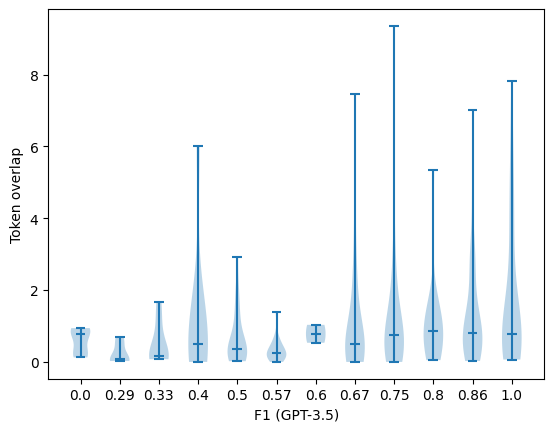

In [491]:
import matplotlib.pyplot as plt

# Bin the data by distinct values of F1
distinct_f1 = np.unique(correlations[:, 0])
binned_data = [correlations[correlations[:, 0] == f1, 2] for f1 in distinct_f1]

# Create the violin plot
plt.violinplot(binned_data, showmedians=True)

# Set the x-axis labels
plt.xticks(range(1, len(distinct_f1) + 1), [round(f1, 2) for f1 in distinct_f1])

# Set the x-axis and y-axis labels
plt.xlabel('F1 (GPT-3.5)')
plt.ylabel('Token overlap')

# Calculate and print the Pearson correlation coefficient
pearson_corr = stats.pearsonr(correlations[:, 0], correlations[:, 2])
print('Pearson', pearson_corr)


# Show the plot
plt.show()


In [492]:
experiment_results = json.load(open('sae_data/experiment_results.json'))

In [508]:
experiment_corrs = np.zeros((len(experiment_results) // 3 , 3))
for i, result in enumerate(experiment_results):
    if i % 3 == 0:
        f1_diff = result['f1_score'] - experiment_results[i + 1]['f1_score']
        corr_diff = result['correlation'] - experiment_results[i + 1]['correlation']
        top_abstracts, zero_abstracts = analyzer.get_feature_activations(10, feature_index = result['feature_index'])
        overlap_scores = [compute_gram_overlap(result['interpretation'], abstract[1], weights = [1, 2, 3, 4]) for abstract in top_abstracts]
        experiment_corrs[i // 3] = [f1_diff, corr_diff, np.mean(overlap_scores)]
        

In [516]:
labels = [result['interpretation'] for result in experiment_results[::3]]

In [522]:
import plotly.express as px

fig = px.scatter(x=experiment_corrs[:, 1], y=experiment_corrs[:, 2], hover_name=labels)

fig.update_traces(textposition='top center')

fig.update_layout(
    xaxis_title='Pearson difference (4o - 3.5)',
    yaxis_title='Weighted n-gram overlap',
)

fig.show()

In [376]:
auto_labels_by_label = {auto_results[i]['label']: auto_results[i] for i in range(len(auto_results))}

In [409]:
ind = auto_labels_by_label['Initial conditions in astrophysics']['index']

In [412]:
top_abstracts, zero_abstracts = analyzer.get_feature_activations(15, feature_index = ind)

In [413]:
top_abstracts

[('3150879',
  "['The ALMA-PILS survey: First detections of deuterated formamide and deuterated isocyanic acid in the interstellar medium']\n\nFormamide (NH<SUB>2</SUB>CHO) has previously been detected in several star-forming regions and is thought to be a precursor for different prebiotic molecules. Its formation mechanism is still debated, however. Observations of formamide, related species, and their isopotologues may provide useful clues to the chemical pathways leading to their formation. The Protostellar Interferometric Line Survey (PILS) represents an unbiased, high angular resolution and sensitivity spectral survey of the low-mass protostellar binary IRAS 16293-2422 with the Atacama Large Millimeter/submillimeter Array (ALMA). For the first time, we detect the three singly deuterated forms of NH<SUB>2</SUB>CHO (NH<SUB>2</SUB>CDO, cis- and trans-NHDCHO), as well as DNCO towards the component B of this binary source. The images reveal that the different isotopologues are all pres

In [513]:
import torch
import numpy as np
from tqdm import tqdm
import os
from torch.utils.data import DataLoader, TensorDataset
from topk_sae import FastAutoencoder  # Assuming train.py contains your FastAutoencoder class

# Set grad to false
torch.set_grad_enabled(False)

# hypers
d_model = 1536
n_dirs = d_model * 2
k = 16
auxk = 24
batch_size = 1024

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the pre-trained model
ae = FastAutoencoder(n_dirs, d_model, k, auxk, multik = 0).to(device)
model_path = 'checkpoints/16_3072_24_auxk_epoch_50.pth'
ae.load_state_dict(torch.load(model_path))
ae.eval()

# Load abstract embeddings
abstract_embeddings = np.load("../data/vector_store/abstract_embeddings.npy")
abstract_embeddings = abstract_embeddings.astype(np.float32)

# Create a DataLoader for efficient batching
dataset = TensorDataset(torch.from_numpy(abstract_embeddings))
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Prepare arrays to store results
num_abstracts = len(abstract_embeddings)
topk_indices = np.zeros((num_abstracts, k), dtype=np.int64)
topk_values = np.zeros((num_abstracts, k), dtype=np.float32)

# Process batches
with torch.no_grad():
    for i, (batch,) in enumerate(tqdm(dataloader, desc="Processing abstracts")):
        batch = batch.to(device)
        _, info = ae(batch)
        
        start_idx = i * batch_size
        end_idx = start_idx + batch.size(0)
        
        topk_indices[start_idx:end_idx] = info['topk_indices'].cpu().numpy()
        topk_values[start_idx:end_idx] = info['topk_values'].cpu().numpy()

# Create directory to save results
#os.makedirs("sae_data", exist_ok=True)

# Save results
np.save("sae_data/topk_indices_16.npy", topk_indices)
np.save("sae_data/topk_values_16.npy", topk_values)

print("Processing complete. Results saved in 'sae_data' folder.")

Processing abstracts: 100%|██████████| 266/266 [00:39<00:00,  6.66it/s]

Processing complete. Results saved in 'sae_data' folder.


# Hierarchical feature splitting

In [2]:
import torch
import numpy as np
from tqdm import tqdm
import os
from torch.utils.data import DataLoader, TensorDataset
from topk_sae import FastAutoencoder  # Assuming train.py contains your FastAutoencoder class

torch.set_grad_enabled(False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 16
d_model = 1536
n_dirs = d_model * 2
k = 16
auxk = 24
batch_size = 1024
ae_16 = FastAutoencoder(n_dirs, d_model, k, auxk, multik = 0).to(device)
model_path_16 = 'checkpoints/16_3072_24_auxk_epoch_50.pth'
ae_16.load_state_dict(torch.load(model_path_16))
ae_16.eval()

# 32
n_dirs = d_model * 4
k = 32
auxk = 48
ae_32 = FastAutoencoder(n_dirs, d_model, k, auxk, multik = 0).to(device)
model_path_32 = 'checkpoints/32_6144_48_auxk_epoch_50.pth'
ae_32.load_state_dict(torch.load(model_path_32))
ae_32.eval()

# 64
n_dirs = d_model * 6
k = 64
auxk = 128
ae_64 = FastAutoencoder(n_dirs, d_model, k, auxk, multik = 0).to(device)
model_path_64 = 'checkpoints/64_9216_128_auxk_epoch_50.pth'
ae_64.load_state_dict(torch.load(model_path_64))
ae_64.eval()

FastAutoencoder(
  (encoder): Linear(in_features=1536, out_features=9216, bias=False)
  (decoder): Linear(in_features=9216, out_features=1536, bias=False)
)

In [15]:
def nn_hierarchy(ae_large, ae_small, dist = "cosine"): # nearest neighbors
    # ae_large: 1536, 9216
    # ae_small: 1536, 3072

    feats = np.arange(ae_small.n_dirs)
    nns = {int(feat): [] for feat in feats}

    # nearest neighbors of features (decoder weights)
    if dist == "cosine":
        sims = np.dot(ae_small.decoder.weight.data.cpu().numpy().T, ae_large.decoder.weight.data.cpu().numpy()) # 3072 x 9216
        matches = np.argmax(sims, axis = 0)
    else:
        sims = np.linalg.norm(ae_small.decoder.weight.data.cpu().numpy().T, ae_large.decoder.weight.data.cpu().numpy().T, metric = 'euclidean')
        matches = np.argmin(sims, axis = 0)
    
    print(matches.shape, np.max(matches), np.min(matches))

    for i, match in enumerate(matches):
        if match in nns.keys():
            nns[int(match)].append(i)
    
    return nns
    


In [16]:
nns_6432 = nn_hierarchy(ae_64, ae_32, dist = 'cosine') # less features: more features
json.dump(nns_6432, open('splitting_6432.json', 'w'))

(9216,) 6143 1


In [14]:
nns_3216 = nn_hierarchy(ae_32, ae_16)
json.dump(nns_3216, open('splitting_3216.json', 'w'))

NameError: name 'nn_hierarchy' is not defined

In [17]:
nns_6432

{0: [],
 1: [5138],
 2: [798],
 3: [6424],
 4: [4604],
 5: [2393, 9202],
 6: [1062, 6828],
 7: [8448],
 8: [64, 2429, 8914],
 9: [335],
 10: [8468],
 11: [2455, 2864],
 12: [],
 13: [],
 14: [1316],
 15: [113, 3426],
 16: [7106],
 17: [260,
  415,
  582,
  694,
  2092,
  2311,
  2632,
  3130,
  4336,
  4807,
  4907,
  5334,
  5786,
  6291,
  6379,
  6452,
  6544,
  6561,
  6687,
  7483,
  7488,
  7592,
  8721,
  9178],
 18: [721, 1560, 4750],
 19: [4922, 7917, 9092],
 20: [2693],
 21: [7155],
 22: [1447, 5460, 5548],
 23: [4526, 7114],
 24: [2256, 6256],
 25: [2376],
 26: [345, 3106],
 27: [477],
 28: [9084],
 29: [],
 30: [2968],
 31: [2390, 3287, 4144, 4548],
 32: [5299],
 33: [],
 34: [8760],
 35: [7323],
 36: [5038],
 37: [],
 38: [2755, 6538, 8759],
 39: [1080, 5336],
 40: [],
 41: [3088],
 42: [3230, 3906, 7255, 7664],
 43: [2940],
 44: [3584],
 45: [],
 46: [522, 3710, 5808, 7201, 8039, 9002, 9183],
 47: [2873],
 48: [2303, 6777],
 49: [1702],
 50: [],
 51: [5163],
 52: [115, 62

In [583]:
nns_6416 = nn_hierarchy(ae_64, ae_16)
json.dump(nns_6416, open('splitting_6416.json', 'w'))

(9216,) 3070 0


In [11]:
auto_results_64 = json.load(open('sae_data/feature_analysis_results.json'))
auto_results_32 = json.load(open('feature_analysis_results_32.json'))
auto_results_16 = json.load(open('feature_analysis_results_16.json'))

In [12]:
get_feature_list([4011], auto_results_32)

['Core properties in astronomy']

In [13]:
get_feature_list([6317], auto_results_64)

['Cores in astronomical contexts']

In [592]:
ind = 10
print(get_feature_list([ind], auto_results_16))
print(get_feature_list(nns_3216[ind], auto_results_32)
print(get_feature_list(nns_6432[ind], auto_results_64))

['Greenhouse effect and climate change']
['Climate stability and habitability of exoplanets', 'Greenhouse effect and climate sensitivity', 'Environmental dependence in astrophysics']


In [606]:
ind = 53
print(get_feature_list([ind], auto_results_16))
print(get_feature_list(nns_6416[ind], auto_results_64))

['Anomalous X-ray Pulsars (AXPs)']
['Detection of stellar magnetic fields', 'Anomalous X-ray Pulsars (AXPs) and Magnetars', 'Anomalous X-ray Pulsar 1E 1048.1-5937', 'Anomalous X-ray Pulsars (AXPs) and Magnetars']
